In [64]:
import models
import matplotlib
import matplotlib.pyplot as plt
from sklearn import mixture, preprocessing, datasets
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
import traintest as tt
from copy import deepcopy

import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Layer Quantization Algorithm 

Looking to development a set of tools to enable stable quantization of a network in an automated way. Specifically classification and machine vision networks. 

Current things to explore:

* Condition number -- Look at condition number of the next layer to assess effects of quantization on the previous

* Conditional density estimation -- create a class by class density estimation at each layer level, and use a distance metric to assess how much additional overlap my be introduced. 
    * find way to combat 

In [68]:
moons_data, moons_label = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

data = (torch.tensor(moons_data, dtype=torch.float, device='cuda') + 1.6) / 4
label = torch.tensor(moons_label, dtype=torch.float)
label = label.type(torch.LongTensor)

train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000)
label_out = label_out.type(torch.LongTensor)

train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)
device=torch.device('cuda:0')

In [69]:
def layer_condition_number(layer, p=2):
    """
    Calculates the condition number of a linear layer in PyTorch.

    Args:
        layer: The linear layer (e.g., torch.nn.Linear)
        p: The norm to use (e.g., 2 for 2-norm)
    """

    if isinstance(layer, torch.nn.Linear):
        weight_matrix = layer.weight.data 
    elif isinstance(layer, torch.ao.nn.quantized.dynamic.modules.linear.Linear):
        weight_matrix = layer.weight().data.dequantize() # convert to float to work with linalg
    else:
        raise ValueError("Layer must be a Linear instance")
    return torch.linalg.cond(weight_matrix, p=p) 
    

# Example usage
linear_layer = torch.nn.Linear(10, 5)
condition_number = layer_condition_number(linear_layer)
print(condition_number)

tensor(2.7345)


In [88]:
# create a model instance
net = models.DxWMoonsNet(d=4)
# create a quantized model instance
model_int8 = torch.ao.quantization.quantize_dynamic(
    net,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [83]:
for layer in net.layers:
    print(layer_condition_number(layer))

tensor(1.0828)
tensor(141.7014)
tensor(660.0733)
tensor(1.1112)


In [79]:
model_int8.layers

ModuleList(
  (0): DynamicQuantizedLinear(in_features=2, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (1-2): 2 x DynamicQuantizedLinear(in_features=32, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (3): DynamicQuantizedLinear(in_features=32, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [80]:
for layer in model_int8.layers:
    print(layer_condition_number(layer))

tensor(1.1103)
tensor(101.3940)
tensor(92.9172)
tensor(1.1920)


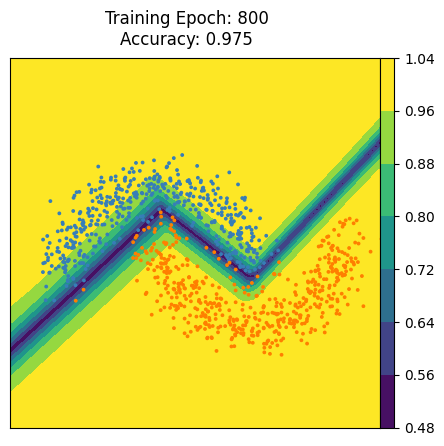

In [89]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4
a
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
optimizer = optim.SGD(param_groups)
f, ax1 = plt.subplots(1, 1)
for epoch in range(801):
    _,acc,_ = tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    plt.suptitle(f'Training Epoch: {epoch}\nAccuracy: {acc}')
    tt.plot_conf(net, data, ax1, device);

In [90]:
for layer in net.layers:
    print(layer_condition_number(layer))

tensor(1.6273, device='cuda:0')
tensor(6588.0396, device='cuda:0')
tensor(190.2603, device='cuda:0')
tensor(6.8764, device='cuda:0')
